In [8]:
# Fornberg's method for computing the conformal map from the interior of the unit disk to 
# the interior of a smooth, closed curve. It is a Newton-like method for
# computing the boundary correspondence. An inner linear system is derived for the New-
# ton updates based on the condition that the negatively indexed Fourier coefficients of the
# (periodic) boundary values must be 0 for the function to be analytic inside the disk

# Fornberg's method for interior regions from B. Fornberg, A numerical
# method for conformal mappings, SIAM J. Sci. Stat. Comput., 1 (1980)
# 386-400 or 
# T. K. DeLillo and J. A. Pfaltzgraff, Numerical conformal
# mapping methods for simply and doubly connected regions, SIAM J. Sci.
# Comput., 19 (1998) 155-171 or 

# M. Badreddine, A comparison of some numerical conformal mapping methods for simply and multiply 
# connected domains, Dissertation - Wichita State University, 4-7
# https://soar.wichita.edu/items/7daf6648-ff71-49df-aed1-6def99e08755 


# n = number of Fourier points.
# iterations = number of iterations.
# tl = length of curve parmeter interval.
# curve = a cell array containing the information about a boundary
# curve. The first element is the name of a boundary curve. The rest
# are parameters which determine the boundary curve. If the curve is
# a spline, the last element of the cell is a case for the spline.
# guess = a cell array determining the initial guess for boundary ... correspondence.
# center = f(0).
# f(n) = f(s(n)) n complex points along curve at s.
# s(n) = n values of parameter 0 ≤ s(n) ≤ tl.
# erri = successive iteration error.
# errfx = discretization error for conformal mapping.
# errsx = discretization error for boundary correspondence.
# See also WEGAI, WEGSM, WDRHCG.s = tl*(k - 1)/n;
# Thomas K. DeLillo, Lianju Wang 06-29-2000.

import numpy as np
from scipy.interpolate import splev, splrep
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt

def fornberg_method(n, itmax, x, y):
    # Fornberg's method for interior regions
    # Parameters:
    # n: number of Fourier points
    # itmax: number of iterations
    # x, y: arrays containing x and y coordinates of the boundary points
    
    # Fit x and y with a spline
    tck, _ = splrep(x, y, s=0)
    t = np.linspace(0, 1, n, endpoint=False)
    s = t * np.max(tck[0])  # Initial guess for boundary correspondence
    
    # Start of Fornberg iteration loop
    for it in range(itmax):
        # Interpolate using spline
        f = splev(s, tck)
        e = np.gradient(f)  # Compute gradient for boundary correspondence
        
        # Discrete Fourier transform
        c = fft(f)
        
        # Apply I(-,N) = diag(1,0,...,0,1,...,1)
        n2 = n // 2
        c[n2+1:] = 0
        
        # Inverse discrete Fourier transform
        c = ifft(c)
        
        # Fix f(0) = center
        center = 0
        a1 = np.real(center * np.conj(e))
        b = -np.real(c * np.conj(e)) + a1
        
        # Conjugate gradient method initialization
        v = np.zeros(n)
        r = b
        p = r
        rr = np.dot(r, r)
        
        # Conjugate gradient iteration
        for in_ in range(n):
            if np.linalg.norm(p) < 1.0e-14:
                break
            c = e * p
            c = fft(c)
            
            # Apply I(-,N) = diag(1,0,...,0,1,...,1)
            c[n2+1:] = 0
            c = ifft(c)
            q = np.real(c * np.conj(e))
            q[0] = q[0] + p[0] * n / 4
            
            alpha = rr / np.dot(p, q)
            v = v + alpha * p
            r = r - alpha * q
            rr1 = np.dot(r, r)
            
            if np.sqrt(rr1) < 1.0e-14:
                break
                
            beta = rr1 / rr
            p = r + beta * p
            rr = rr1
        
        # Update boundary correspondence
        sl = s
        ne = np.abs(e)
        s = s + v / ne
        
        # Successive iteration error
        erri = np.linalg.norm(s - sl, np.inf)
    
    # Return results
    return f, s, erri

In [9]:
# Testing of method
n = 200000
itmax = 1000

# Define coordinates for a square
x_square = np.array([-2, 2, 2, -2, -2])
y_square = np.array([-2, -2, 2, 2, -2])

# Interpolate more points to get 10 points on each side
x = np.asarray(np.interp(np.linspace(0, len(x_square) - 1, 10), np.arange(len(x_square)), x_square))
y = np.asarray(np.interp(np.linspace(0, len(y_square) - 1, 10), np.arange(len(y_square)), y_square))

# Ensure x is strictly increasing
x_sorted_idx = np.argsort(x)
x = x[x_sorted_idx]
y = y[x_sorted_idx]

print(x)
print(y)

f, s, erri = fornberg_method(n, itmax, x, y)
print(f)
print(s)
print(erri)

[-2.         -2.         -2.         -2.         -0.66666667 -0.22222222
  1.11111111  1.55555556  2.          2.        ]
[-2.          1.55555556 -0.22222222 -2.          2.         -2.
  2.         -2.         -0.66666667  1.11111111]


ValueError: too many values to unpack (expected 2)

C:\Users\Nate\AppData\Local\Temp\ipykernel_13044\1404872905.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  f[0, :] = 0.1 + 0.9 * alpha / (alpha * cs + 1j * ss)
C:\Users\Nate\AppData\Local\Temp\ipykernel_13044\1404872905.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  f[1, :] = -1 + 1.2j + 0.8 * alpha / (alpha * cs + 1j * ss)
C:\Users\Nate\AppData\Local\Temp\ipykernel_13044\1404872905.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  f[2, :] = -2 + 0.8 * alpha / (alpha * cs + 1j * ss)
C:\Users\Nate\AppData\Local\Temp\ipykernel_13044\1404872905.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  f[3, :] = -0.5 - 1.5j + cs - 0.6j * ss


AttributeError: module 'matplotlib.pyplot' has no attribute 'hold'

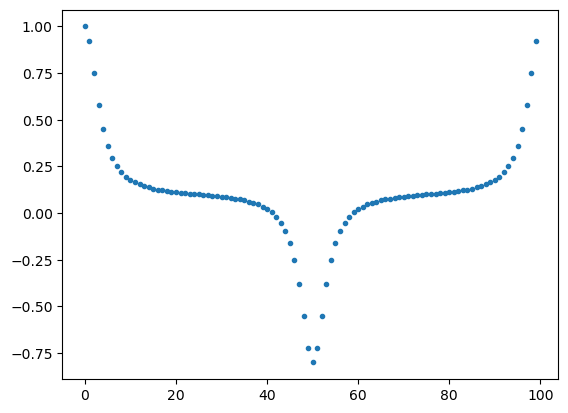

In [3]:
# visualization of Fornberg's method
# not finished 